In [1]:

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

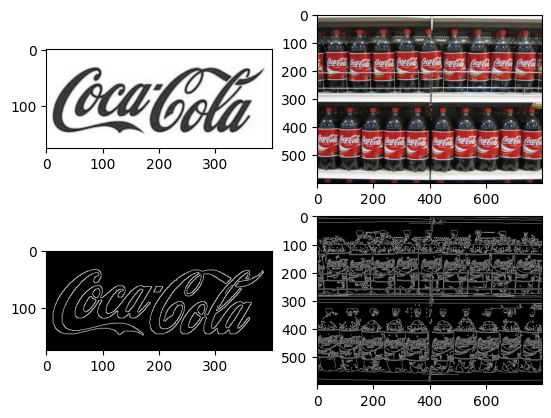

In [12]:
target = cv.imread('./images/coca_multi.png')

target_rgb= cv.cvtColor(target, cv.COLOR_BGR2RGB)
target_gray= cv.cvtColor(target, cv.COLOR_BGR2GRAY)

template = cv.imread('./template/pattern.png',0) 

target_edges = cv.Canny(target_gray, threshold1=5, threshold2=200)
template_edges = cv.Canny(template, threshold1=5, threshold2=200)


plt.figure()
plt.subplot(2,2,1)
plt.imshow(template, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(target_rgb)
plt.subplot(2,2,3)
plt.imshow(template_edges, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(target_edges, cmap='gray')





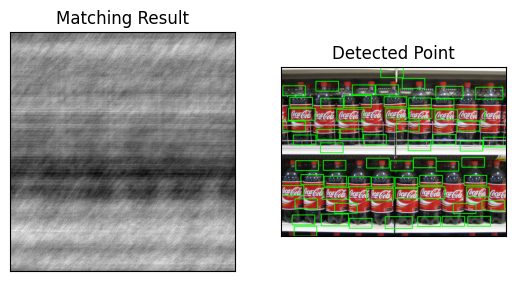

In [72]:
w, h = template.shape[::-1]


boxes = []
scores = []

for scale in np.linspace(0.2, 1, 20):
    # Redimensiona la plantilla
    width = int(template_edges.shape[1] * scale)
    height = int(template_edges.shape[0] * scale)

    # Prevenir que la plantilla sea más grande que la imagen principal
    if width > target_edges.shape[1] or height > target_edges.shape[0]:
        continue

    resized_template = cv.resize(template_edges, (width, height), interpolation=cv.INTER_AREA)

     
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(target_edges, resized_template, cv.TM_CCOEFF_NORMED)
    y_coords, x_coords = np.where(res >= 0.1)

    for i in range(len(x_coords)):
        x = x_coords[i]
        y = y_coords[i]
        
        scores.append(res[y, x])
        boxes.append([x, y, width, height])

# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = target_rgb.copy()

score_threshold = 0.1
nms_threshold = 0

indices = cv.dnn.NMSBoxes(boxes, scores, score_threshold, nms_threshold)

for i in indices:
    (x, y, w, h) = boxes[i]
    top_left = (x,y)
    bottom_right = (x+w, y+h)
    cv.rectangle(img_salida, top_left, bottom_right, ((0, 255, 0)), 2)

# Graficamos el procesamiento y la salida
#----------------------------------------
plt.figure()

# Resultado de coincidencia
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

# Imagen original con recuadros
plt.subplot(122),plt.imshow(img_salida)
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

plt.show()

[ 6.78928429e-03  5.89965982e-03  6.38895342e-03  9.54711903e-03
  1.22604724e-02  9.50263813e-03  9.50263813e-03  1.17711797e-02
  1.13263670e-02  1.03922617e-02  8.56853276e-03  9.45815630e-03
  9.90296900e-03  6.25548791e-03  5.81068639e-03  5.81069756e-03
  5.81069756e-03  5.81069756e-03  5.81069756e-03  7.63442693e-03
  5.81070827e-03  4.92107309e-03  8.07923917e-03  8.47959146e-03
  1.07481116e-02  1.12374052e-02  5.76621620e-03  7.10065244e-03
  1.11929234e-02  8.47954862e-03  2.56356923e-03  2.11875723e-03
  3.49767460e-03  8.63635819e-03  7.74338422e-03  5.91278682e-03
  3.63570265e-03 -2.55026061e-05  2.69809063e-03  2.69809063e-03
  2.69807968e-03  4.08218987e-03  7.74338422e-03  5.01981284e-03
  2.74270657e-03  1.91351628e-05  1.40324526e-03  1.91461058e-05
  1.91461058e-05  1.40324526e-03  6.37838748e-05  5.10909921e-03
 -1.76680239e-03  9.56758100e-04  1.89439196e-03  1.44791580e-03
  2.29623052e-03  4.12682770e-03  4.61795228e-03  2.78737722e-03
  1.84972142e-03  2.29619

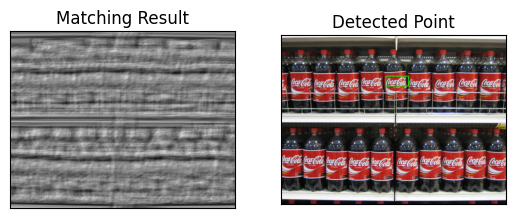

In [28]:
# Redimensiona la plantilla
scale = 0.2
width = int(template_edges.shape[1] * scale)
height = int(template_edges.shape[0] * scale)

resized = cv.resize(template_edges, (width, height), interpolation=cv.INTER_AREA)

# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = target_rgb.copy()
    
# Aplicamos la coincidencia de patrones
#--------------------------------------
res = cv.matchTemplate(target_edges, resized, cv.TM_CCOEFF_NORMED)

print(res[0])
# Encontramos los valores máximos y mínimos
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

# Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
top_left = max_loc

# Marcamos el lugar donde lo haya encontrado
#----------------------------------------
bottom_right = (top_left[0] + width, top_left[1] + height)
cv.rectangle(img_salida,top_left, bottom_right, ((0, 255, 0)), 2)

# Graficamos el procesamiento y la salida
#----------------------------------------
plt.figure()

# Resultado de coincidencia
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

# Imagen original con recuadros
plt.subplot(122),plt.imshow(img_salida)
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

plt.show()